## Random Forest prediction of FIFA Man of the Match 

- tune parameters for random forest
- what are top 3 features?


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection as skms
import sklearn.preprocessing as skpp

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve


In [2]:
raw_data = pd.read_csv('/Users/iMotz/Propulsion/Machine_learning/data_sets/FIFA_2018_Statistics.csv')
raw_data = pd.DataFrame(raw_data)
raw_data.head(5)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


#### clean data

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 27 columns):
Date                      128 non-null object
Team                      128 non-null object
Opponent                  128 non-null object
Goal Scored               128 non-null int64
Ball Possession %         128 non-null int64
Attempts                  128 non-null int64
On-Target                 128 non-null int64
Off-Target                128 non-null int64
Blocked                   128 non-null int64
Corners                   128 non-null int64
Offsides                  128 non-null int64
Free Kicks                128 non-null int64
Saves                     128 non-null int64
Pass Accuracy %           128 non-null int64
Passes                    128 non-null int64
Distance Covered (Kms)    128 non-null int64
Fouls Committed           128 non-null int64
Yellow Card               128 non-null int64
Yellow & Red              128 non-null int64
Red                       128 non-nul

In [5]:
data = raw_data.drop(columns = ['Date','Team','Opponent','Round','PSO','Own goal Time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 21 columns):
Goal Scored               128 non-null int64
Ball Possession %         128 non-null int64
Attempts                  128 non-null int64
On-Target                 128 non-null int64
Off-Target                128 non-null int64
Blocked                   128 non-null int64
Corners                   128 non-null int64
Offsides                  128 non-null int64
Free Kicks                128 non-null int64
Saves                     128 non-null int64
Pass Accuracy %           128 non-null int64
Passes                    128 non-null int64
Distance Covered (Kms)    128 non-null int64
Fouls Committed           128 non-null int64
Yellow Card               128 non-null int64
Yellow & Red              128 non-null int64
Red                       128 non-null int64
Man of the Match          128 non-null object
1st Goal                  94 non-null float64
Goals in PSO              128 non-null

#### check nans, remove or replace

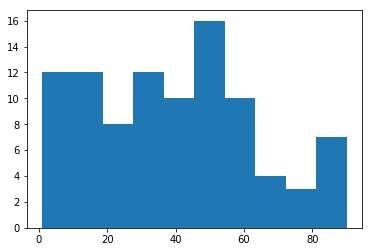

In [7]:
# categorize 1st goal: 
plt.hist(data['1st Goal'])
None

In [8]:
# convert times into bins (include 0 and inf as last boundaries)

bins = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 120.0, np.inf]
bin_names = ['first_15', '15-30', '30-45', '45-60', '60-75','75-90','90-120','never']

data['First_goal'] = pd.cut(data['1st Goal'], bins, labels = bin_names)


In [9]:
# replace nans with 'never'
data['First_goal'] = data['First_goal'].fillna('never')

# convert categories into object
data['First_goal'] = data['First_goal'].astype('object')

data[['1st Goal','First_goal']].head(10)

,1st Goal,First_goal
0,12.0,first_15
1,NaN,never
2,NaN,never
3,89.0,75-90
4,NaN,never
5,90.0,75-90
6,4.0,first_15
7,24.0,15-30
8,58.0,45-60
9,62.0,60-75


In [10]:
# own goals: replace nan by 0
data['Own goals'] = data['Own goals'].fillna(0)


In [11]:
# drop col
data_clean = data.drop(columns = ['1st Goal'])
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 21 columns):
Goal Scored               128 non-null int64
Ball Possession %         128 non-null int64
Attempts                  128 non-null int64
On-Target                 128 non-null int64
Off-Target                128 non-null int64
Blocked                   128 non-null int64
Corners                   128 non-null int64
Offsides                  128 non-null int64
Free Kicks                128 non-null int64
Saves                     128 non-null int64
Pass Accuracy %           128 non-null int64
Passes                    128 non-null int64
Distance Covered (Kms)    128 non-null int64
Fouls Committed           128 non-null int64
Yellow Card               128 non-null int64
Yellow & Red              128 non-null int64
Red                       128 non-null int64
Man of the Match          128 non-null object
Goals in PSO              128 non-null int64
Own goals                 128 non-null 

#### Explore features

In [12]:
# binary/object will be disregarded
corr_values = data_clean.corr()

corr_values.style.background_gradient(cmap = 'coolwarm')


,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO,Own goals
Goal Scored,1,0.0347589,0.144915,0.461702,-0.020374,-0.0870721,0.0404461,0.0451052,0.0468149,-0.118893,0.135688,0.0439709,0.0143552,0.0303312,-0.0488382,-0.0350311,-0.0897138,-0.0112042,-0.066164
Ball Possession %,0.0347589,1,0.541185,0.297234,0.361767,0.52151,0.542992,0.0577056,0.273831,-0.293658,0.713872,0.880611,-0.0590544,-0.296477,-0.205511,0.0909235,0.0243157,-0.0100861,0.0594988
Attempts,0.144915,0.541185,1,0.731243,0.718972,0.754307,0.686892,-0.016508,0.14085,-0.268217,0.397614,0.582831,0.171381,-0.248773,-0.185544,-0.074594,0.00979518,0.149836,-0.0416767
On-Target,0.461702,0.297234,0.731243,1,0.324672,0.331333,0.407576,0.0731763,0.0930903,-0.321557,0.291659,0.348099,0.0654752,-0.192242,-0.115259,-0.0517425,-0.0234389,0.040322,-0.0718796
Off-Target,-0.020374,0.361767,0.718972,0.324672,1,0.299712,0.440633,-0.0959193,0.142367,-0.126644,0.18976,0.398949,0.22993,-0.186858,-0.124094,-0.145577,-0.119332,0.185807,-0.0924743
Blocked,-0.0870721,0.52151,0.754307,0.331333,0.299712,1,0.636172,-0.00223071,0.086021,-0.14296,0.401699,0.532913,0.0821113,-0.174606,-0.163111,0.0337169,0.165295,0.10822,0.0748787
Corners,0.0404461,0.542992,0.686892,0.407576,0.440633,0.636172,1,-0.0340542,0.0852158,-0.233787,0.330363,0.524661,0.0997002,-0.165382,-0.169929,0.0145431,0.11796,0.088997,-0.0288764
Offsides,0.0451052,0.0577056,-0.016508,0.0731763,-0.0959193,-0.00223071,-0.0340542,1,0.0891211,0.00653936,0.127421,0.0347152,0.0313239,-0.0400844,-0.0477565,0.228531,-0.0364324,-0.0648922,-0.0704606
Free Kicks,0.0468149,0.273831,0.14085,0.0930903,0.142367,0.086021,0.0852158,0.0891211,1,-0.231637,0.131951,0.175695,0.076927,0.0803409,-0.0267409,0.0297014,-0.104164,0.138046,0.0188671
Saves,-0.118893,-0.293658,-0.268217,-0.321557,-0.126644,-0.14296,-0.233787,0.00653936,-0.231637,1,-0.19074,-0.264425,0.125645,0.0749756,0.0096697,0.140307,0.0168754,0.110014,0.0693399


#### split data into train and test

In [13]:
data_pred = data_clean.drop(columns = ['Man of the Match'])
y = data_clean['Man of the Match']


In [14]:
X_train_raw, X_test_raw, y_train, y_test = skms.train_test_split(data_pred, y, test_size = 0.2)

In [15]:
# check for balanced output
y_train.value_counts()

No     53
Yes    49
Name: Man of the Match, dtype: int64

#### Transform categorical, rest can stay as it is

In [16]:
# select object cols
X_train_raw_cat = X_train_raw.select_dtypes(['object'])

# import encoder object
one_hot = skpp.OneHotEncoder(handle_unknown = 'ignore') # ! if you encounter a new cat in test set, ignore it

# fit encoder to X train, transform
X_train_cat = one_hot.fit_transform(X_train_raw_cat).toarray() # alt for specific cols: one_hot.fit(data[['col1', 'col2']])

# extract new col names:
cat_col_names = one_hot.get_feature_names().tolist()

# convert to data frame
X_train_cat = pd.DataFrame(columns = cat_col_names, data = X_train_cat)


In [17]:
# get numerical, create new index
X_train_num = X_train_raw.select_dtypes(['int64','float64']).reset_index(drop = True)

# merge (have problems using concat!!!)
X_train = pd.merge(X_train_num, X_train_cat, how = 'left', left_index = True, right_index = True)


In [18]:
# transform X test (DO NOT FIT!)

X_test_raw_cat = X_test_raw.select_dtypes(['object'])
X_test_cat = one_hot.transform(X_test_raw_cat).toarray()
# convert to df
X_test_cat = pd.DataFrame(columns = cat_col_names, data = X_test_cat)
X_test_num = X_test_raw.select_dtypes(['int64','float64']).reset_index(drop = True)
# merge
X_test = pd.merge(X_test_num, X_test_cat, how = 'left', left_index = True, right_index = True)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 26 columns):
Goal Scored               26 non-null int64
Ball Possession %         26 non-null int64
Attempts                  26 non-null int64
On-Target                 26 non-null int64
Off-Target                26 non-null int64
Blocked                   26 non-null int64
Corners                   26 non-null int64
Offsides                  26 non-null int64
Free Kicks                26 non-null int64
Saves                     26 non-null int64
Pass Accuracy %           26 non-null int64
Passes                    26 non-null int64
Distance Covered (Kms)    26 non-null int64
Fouls Committed           26 non-null int64
Yellow Card               26 non-null int64
Yellow & Red              26 non-null int64
Red                       26 non-null int64
Goals in PSO              26 non-null int64
Own goals                 26 non-null float64
x0_15-30                  26 non-null float64
x0_30-45     

### Remove more features:

In [19]:
more_cols_drop = ['Yellow & Red','Red','Goals in PSO','Own goals','x0_15-30','x0_30-45','x0_60-75','x0_75-90']

X_train = X_train.drop(columns = more_cols_drop)
X_test = X_test.drop(columns = more_cols_drop)


,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,x0_45-60,x0_first_15,x0_never
0,2,54,22,7,11,4,8,1,17,0,79,622,143,23,2,0.0,0.0,0.0
1,1,48,10,3,5,2,7,3,15,6,82,342,110,18,2,1.0,0.0,0.0
2,2,60,12,3,5,4,6,1,15,5,87,594,103,9,3,0.0,0.0,0.0
3,1,51,14,5,5,4,5,0,8,5,85,520,114,5,0,0.0,0.0,0.0
4,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0.0,0.0,0.0
5,1,36,9,4,4,1,0,4,20,5,77,284,102,18,3,0.0,0.0,0.0
6,2,54,7,3,2,2,2,2,18,5,84,449,105,8,2,0.0,0.0,0.0
7,2,59,13,5,6,2,5,0,24,5,89,485,97,7,0,0.0,0.0,0.0
8,0,53,16,4,10,2,7,1,20,1,77,466,107,23,1,0.0,0.0,1.0
9,1,34,9,3,5,1,3,0,17,2,76,244,98,20,2,1.0,0.0,0.0


### Hyperparameter Tuning with Random Search

- start with huge ranges!

- run Rand search several times, is very fast

- check if result is always in same range --> limit it further

In [ ]:
# RandomizedSearchCV(estimator, param_distributions, n_iter=10, scoring=None, n_jobs=None, 
#                    iid=’warn’, refit=True, cv=’warn’, verbose=0, pre_dispatch=‘2*n_jobs’, 
#                    random_state=None, error_score=’raise-deprecating’, return_train_score=False)

# n_iter : how many rand samples you want to take from all combinations of params
# n_jobs = -1 # uses all cores of my mac
# verbose = 1 # prints updates

In [20]:
parameters_init = {'n_estimators': list(range(100, 500, 20)), 'criterion': ['gini','entropy'], 
                 'max_depth': list(range(4, 30, 2)), 'min_samples_split': [2,4,6,8,10] , 
                 'min_samples_leaf': [1,2,3,4,5,6]}

# to collect results in dictionary:
dictkeys = list(parameters_init.keys())   # get parameter names
empty_list = [[] for x in range(len(dictkeys))]  # create list of empty lists
result_dict = dict(zip(dictkeys,empty_list)) # merge to dict


rand_for = RandomForestClassifier()

number_rand_tries = 20

for i in range(number_rand_tries):
    
    myRS = skms.RandomizedSearchCV(estimator = rand_for, param_distributions = parameters_init, 
                               scoring = 'roc_auc', cv = 3, n_iter = 20,
                               n_jobs = -1, verbose = 1).fit(X_train, y_train)
    # get best params of n_iter tries
    curr_params_RandS = myRS.best_params_
    
    # append best params to dict
    for key in dictkeys:
        result_dict[key].append(curr_params_RandS[key])
        
        

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.4s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.1s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.4s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.0s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.9s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.8s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.0s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.8s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.4s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.7s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.4s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.4s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.5s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.9s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   34.4s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.7s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


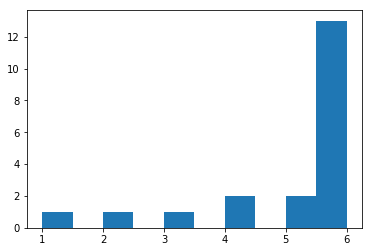

In [26]:
plt.hist(result_dict['min_samples_leaf'])
None

In [27]:
parameters_better = {'n_estimators': list(range(220, 340, 20)), 'criterion': ['gini'], 
                 'max_depth': list(range(4, 6, 1)), 'min_samples_split': list(range(6, 8, 1)) , 
                 'min_samples_leaf': list(range(5, 7, 1))}


### Hyperparameter FINE Tuning with Grid search

- take already optimized ranges from random search

In [28]:
# skms.GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, iid=’warn’, 
#                                refit=True, cv=’warn’, verbose=0, pre_dispatch=‘2*n_jobs’, 
#                                error_score=’raise-deprecating’, return_train_score=False)

rand_for = RandomForestClassifier()

myGS = skms.GridSearchCV(estimator = rand_for, scoring = 'roc_auc', param_grid = parameters_better, 
                         cv = 3, n_jobs = -1, verbose = 1).fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    8.8s finished
/Users/iMotz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
best_params_GridS = myGS.best_params_
best_params_GridS

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 6,
 'min_samples_split': 7,
 'n_estimators': 240}

In [30]:
# retrieve best model
randFor_opti = myGS.best_estimator_

### Use best model with optimized=tuned parameters

In [31]:
# cross val model
mean_roc_auc_opti = np.mean(skms.cross_val_score(randFor_opti, X_train, y_train, cv = 6, scoring = 'roc_auc'))


In [32]:
# show result
print('ROC_AUC score of model after hyperparameter tuning = %.6f. ' % mean_roc_auc_opti)

ROC_AUC score of model after hyperparameter tuning = 0.733828. 


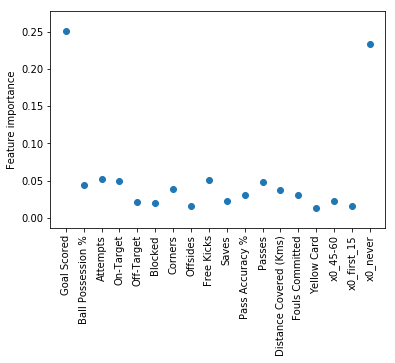

In [33]:
# plot feature importance
feature_imp = randFor_opti.feature_importances_

# get feature names
feature_names = list(X_train)

plt.scatter(range(1, len(feature_imp)+1), feature_imp)
plt.xticks(range(1, len(feature_imp)+1),feature_names, rotation = 90)
plt.ylabel('Feature importance')
None

In [34]:
# show top 3 important features

feature_imp_df = pd.DataFrame(feature_imp, feature_names)
feature_imp_df = feature_imp_df.rename(columns = {0:'Feature_Importance'})

feature_imp_df = feature_imp_df.sort_values('Feature_Importance', ascending = False)
feature_imp_df.head(3)

,Feature_Importance
Goal Scored,0.251773
x0_never,0.233408
Attempts,0.051832


### Test model on TEST set

In [70]:
predicted_y = randFor_opti.predict(X_test).tolist()

compare_df = pd.DataFrame(columns = ['True_y'], data = y_test.tolist() )
compare_df['Predicted_y'] = predicted_y
compare_df.head(5)

,True_y,Predicted_y
0,Yes,Yes
1,Yes,Yes
2,No,No
3,No,Yes
4,Yes,Yes


In [63]:
predicted_prob_y = randFor_opti.predict_proba(X_test)

In [82]:
# calculate true pos and false pos rate

# convert true y into binary:
compare_df['True_y_binary'] = 0
compare_df['True_y_binary'][compare_df['True_y'] == 'Yes'] = 1

fpr_test, tpr_test, _ = roc_curve(compare_df.True_y_binary, predicted_prob_y[:,1])

roc_df_test = pd.DataFrame({'fpr':fpr_test, 'tpr':tpr_test})

/Users/iMotz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


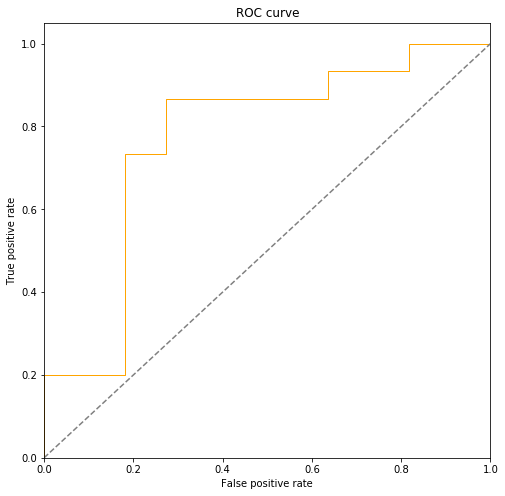

In [83]:
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(fpr_test, tpr_test, 'orange', linewidth=1)
plt.plot([0, 1], [0, 1],'grey', linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('ROC curve')
None